In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import StringLookup
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

In [35]:
DIMENSION = 20 # 特徴量の数
sc = StandardScaler()

In [36]:
# データセット分割
data_table = pd.read_csv(f'../datasets/end-to-end/data_list.csv')
split_idx = int(0.5 * len(data_table))
train_samples = data_table[:split_idx]
test_samples = data_table[split_idx:]
val_split_idx  = int(0.5 * len(test_samples))
val_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

print(f'Total training samples: {len(train_samples)}')
print(f'Total validation samples: {len(val_samples)}')
print(f'Total test samples: {len(test_samples)}')

Total training samples: 9
Total validation samples: 4
Total test samples: 5


In [37]:
# データセットに含まれる文字列の最大長、フレーム数の最大長
max_label_len = 0
max_frame_len = 0
total_character = 0
total_frame = 0

train_labels = []
train_data_paths = []
characters = set()

for _, data in train_samples.iterrows():
  # print(data)
  train_labels.append(data['label'])
  for c in data['label']:
    characters.add(c)
  max_label_len = max(max_label_len, len(data['label']))
  file_path = data['feature_file_ptah']
  train_data_paths.append(f'.{file_path}')
  val = pd.read_csv(f'.{file_path}')
  max_frame_len = max(max_frame_len, len(val.index))
  total_frame += len(val.index)


In [38]:
val_labels = []
val_data_paths = []
for _, data in val_samples.iterrows():
  val_labels.append(data['label'])
  for c in data['label']:
    characters.add(c)
  max_label_len = max(max_label_len, len(data['label']))
  file_path = data['feature_file_ptah']
  val_data_paths.append(f'.{file_path}')
  val = pd.read_csv(f'.{file_path}')
  max_frame_len = max(max_frame_len, len(val.index))
  total_frame += len(val.index)


test_labels = []
test_data_paths = []
for _, data in test_samples.iterrows():
  test_labels.append(data['label'])
  for c in data['label']:
    characters.add(c)
  max_label_len = max(max_label_len, len(data['label']))
  file_path = data['feature_file_ptah']
  test_data_paths.append(f'.{file_path}')
  val = pd.read_csv(f'.{file_path}')
  max_frame_len = max(max_frame_len, len(val.index))
  total_frame += len(val.index)

In [39]:
# 特徴量の長さをmax_frame_lenで揃える
def build_dataset(paths, max_frame_len):
  padding_data = np.empty((0, max_frame_len, DIMENSION))
  for path in paths:
    val = pd.read_csv(path)
    padding_length = max_frame_len - len(val.index)
    tmp = pd.DataFrame(index=range(padding_length), columns=val.columns)
    tmp.fillna(0, inplace=True)
    val = val.append(tmp, ignore_index=True)
    
    padding_data = np.vstack((padding_data , [val.values]))
  return padding_data.astype(np.float32)

In [40]:
train_data = build_dataset(train_data_paths, max_frame_len)
val_data = build_dataset(val_data_paths, max_frame_len)
test_data = build_dataset(test_data_paths, max_frame_len)

C:\Users\myasu\AppData\Local\Temp\ipykernel_38052\3203409968.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = val.append(tmp, ignore_index=True)
C:\Users\myasu\AppData\Local\Temp\ipykernel_38052\3203409968.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = val.append(tmp, ignore_index=True)
C:\Users\myasu\AppData\Local\Temp\ipykernel_38052\3203409968.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = val.append(tmp, ignore_index=True)
C:\Users\myasu\AppData\Local\Temp\ipykernel_38052\3203409968.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val = val.append(tmp, ignore_index=True)
C:\Users\myasu\AppData\Local

In [41]:
# 文字と数字のマッピング
AUTOTUNE = tf.data.AUTOTUNE
characters = sorted(characters) # 降順にソート
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [42]:
# データセットの情報を確認
print(f'--情報--')
# データセットの量を確認
print(f'一つの動画によるフレームの最大長: {max_frame_len}\n合計のフレーム数: {total_frame}')
# データセットに含まれるラベル文字を確認
print(f'ラベルの最大長{max_label_len}\n文字の種類数: {len(characters)}\n出現文字: {characters}')

--情報--
一つの動画によるフレームの最大長: 498
合計のフレーム数: 3766
ラベルの最大長15
文字の種類数: 45
出現文字: ['あ', 'い', 'う', 'え', 'ぉ', 'か', 'が', 'き', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'し', 'じ', 'す', 'せ', 'そ', 'だ', 'ち', 'っ', 'つ', 'て', 'で', 'と', 'ど', 'ね', 'の', 'は', 'ひ', 'ふ', 'ぶ', 'ま', 'み', 'め', 'も', 'ょ', 'り', 'る', 'れ', 'ろ', 'わ', 'ん', 'ー']


In [43]:
batch_size = 32
padding_token = 99

def preprocess_data(data):
	return data

def vectorize_label(label):
	label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
	length = tf.shape(label)[0]
	pad_amount = max_label_len - length
	label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
	return label

def process_datas_labels(data, label):
	data = preprocess_data(data)
	label = vectorize_label(label)
	return {"input": data, "label": label}


def prepare_dataset(data, labels):
	dataset = tf.data.Dataset.from_tensor_slices((data, labels)).map(
		process_datas_labels, num_parallel_calls=AUTOTUNE
	).shuffle(20)
	return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [45]:
train_ds = prepare_dataset(train_data, train_labels)
val_ds = prepare_dataset(val_data, val_labels)
test_ds = prepare_dataset(test_data, test_labels)

In [46]:
class CTCLayer(keras.layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    return y_pred

In [47]:
# モデルの構築
def build_model():
  input_data = keras.Input(shape=(max_frame_len, DIMENSION), name="input")
  labels = keras.layers.Input(name="label", shape=(None,))

  x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.2))(input_data)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
  x = keras.layers.Dense(256, activation="relu", name="dense1")(x)
  x = keras.layers.Dense(128, activation="relu", name="dense2")(x)
  x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="output")(x)

  output = CTCLayer(name="ctc_loss")(labels, x)

  model = keras.models.Model(inputs=[input_data, labels], outputs=output, name="fingerspelling_recognizer")
  opt = keras.optimizers.Adam()
  model.compile(optimizer=opt)
  return model

model = build_model()
model.summary()

Model: "fingerspelling_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 498, 20)]    0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 498, 256)    152576      ['input[0][0]']                  
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 498, 128)    164352      ['bidirectional_2[0][0]']        
 )                                                                                                
                                                                          

In [48]:
prediction_model = keras.models.Model(
  model.get_layer(name="input").input, model.get_layer(name="output").output
)

epochs = 50  # To get good results this should be at least 50.
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

# Train the model.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/50
1/1 [==============================] - 9s 9s/step - loss: 1879.0413 - val_loss: 1758.5881
Epoch 2/50
1/1 [==============================] - 1s 501ms/step - loss: 1803.0038 - val_loss: 1643.1167
Epoch 3/50
1/1 [==============================] - 0s 274ms/step - loss: 1712.6493 - val_loss: 1505.8181
Epoch 4/50
1/1 [==============================] - 0s 233ms/step - loss: 1606.0365 - val_loss: 1354.6315
Epoch 5/50
1/1 [==============================] - 0s 227ms/step - loss: 1482.9966 - val_loss: 1198.7533
Epoch 6/50
1/1 [==============================] - 0s 185ms/step - loss: 1344.0789 - val_loss: 1035.7837
Epoch 7/50
1/1 [==============================] - 0s 184ms/step - loss: 1179.5216 - val_loss: 816.6752
Epoch 8/50
1/1 [==============================] - 0s 181ms/step - loss: 941.9684 - val_loss: 417.5336
Epoch 9/50
1/1 [==============================] - 0s 164ms/step - loss: 487.3574 - val_loss: 25.6686
Epoch 10/50
1/1 [==============================] - 0s 168ms/step - loss: 

In [49]:
import os
import datetime

# 現在時刻(yyyymmdd_hhmmss形式)のフォルダを作る
now = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
os.mkdir(f'models/{now}')

<Figure size 640x480 with 0 Axes>

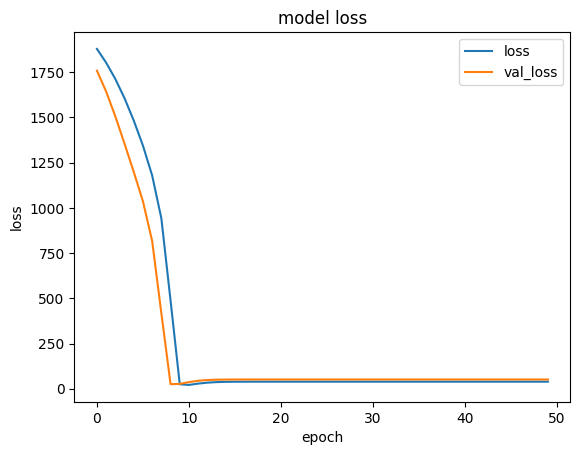

In [50]:
import matplotlib.pyplot as plt
hist_df = pd.DataFrame(history.history)
# 可視化
fig = plt.figure()
hist_df[['loss', 'val_loss']].plot()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
model_loss_fig_path = f'models/{now}/model_loss.png'
plt.savefig(model_loss_fig_path, dpi=300)
plt.show()

In [51]:
model_save_path = f'models/{now}/ja_fingerspelling.hdf5'
tflite_model_save_path = f'models/{now}/ja_fingerspelling.tflite'

# 学習済モデルの保存
prediction_model.save(model_save_path, include_optimizer=False)

# TfLiteモデルの保存
converter = tf.lite.TFLiteConverter.from_keras_model(prediction_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_quantized_model = converter.convert()
open(tflite_model_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\myasu\AppData\Local\Temp\tmpd_f83o4e\assets


INFO:tensorflow:Assets written to: C:\Users\myasu\AppData\Local\Temp\tmpd_f83o4e\assets


In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  # Use greedy search. For complex tasks, you can use beam search.
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
    :, :max_label_len
  ]
  # Iterate over the results and get back the text.
  output_text = []
  for res in results:
    res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    output_text.append(res)
  return output_text

In [ ]:
prediction_result_save_path = f'models/{now}/prediction_result.csv'
accuracy_save_path = f'models/{now}/accuracy.txt'

prediction_result = pd.DataFrame(columns=['AC_label', 'Prediction_result'])
acc_count = 0

for batch in test_ds.take(1):
  for i in range(len(test_samples)):
    batch_data = batch["input"][i]
    preds = prediction_model.predict(np.array([batch_data]))
    pred_texts = decode_batch_predictions(preds)

    prediction_result = pd.concat([prediction_result, pd.DataFrame({'AC_label':[test_samples['label'].values[i]], 'Prediction_result':[pred_texts[0]]})])
    if test_samples['label'].values[i] is pred_texts[0]:
      acc_count += 1

# 正解ラベルとモデルの出力を一緒に保存
prediction_result.to_csv(prediction_result_save_path, index=False)

# 正解率を計算、保存
accuracy = acc_count / len(test_samples)
open(accuracy_save_path, 'w', encoding='utf-8').write(f'Accuracy: {accuracy}')
print(f'Accuracy: {accuracy}')

In [ ]:
df = pd.read_csv('../datasets/end-to-end/ja/00000001/attribute.csv')
padding_length = max_frame_len - len(df.index)
tmp = pd.DataFrame(index=range(padding_length), columns=df.columns)
tmp.fillna(0, inplace=True)
df = df.append(tmp, ignore_index=True)
preds = prediction_model.predict(np.array([df.values]))
pred_texts = decode_batch_predictions(preds)
print(f'AC: ')
print(f"Prediction: {pred_texts[0]}")